In [34]:
import pandas as pd
import numpy as np
import riskfolio as rp
import matplotlib.pyplot as plt
import pypfopt as ppo
import sqlite3
import os
import holidays

In [35]:
ibov_close = pd.read_csv(r'C:\Users\loren\Documents\Programação\Github\quantamental-Dev_Wizards\data\ativos_ibov\ivob_close.csv')

threshold = len(ibov_close)
ibov_close.dropna(thresh=threshold, axis=1, inplace=True)

ibov_close['Date'] = pd.to_datetime(ibov_close['Date'])

ibov_close.set_index('Date', inplace=True)
ibov_close = ibov_close.loc['2014-01-01':'2020-12-31']
returns = ibov_close.pct_change().dropna()

In [36]:
# Portfolio simples com rp
port = rp.Portfolio(returns=returns)

method_mu = 'hist'    # Method to estimate expected returns based on historical data.
method_cov = 'hist'   # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov)

# Estimate optimal portfolio:
model = 'Classic'     # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV'             # Risk measure used, this time will be variance
obj = 'Sharpe'        # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True           # Use historical scenarios for risk measures that depend on scenarios
rf = 0                # Risk free rate
l = 0                 # Risk aversion factor, only useful when obj is 'Utility'

w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w.T)

,BBAS3.SA,BBDC3.SA,BRAP4.SA,BRFS3.SA,BRKM5.SA,CMIG4.SA,CPFE3.SA,CPLE6.SA,CSNA3.SA,CYRE3.SA,...,GOAU4.SA,ITSA4.SA,PETR3.SA,PETR4.SA,SBSP3.SA,TRPL4.SA,USIM5.SA,VALE3.SA,VIVT3.SA,WEGE3.SA
weights,1.215601e-10,1.455074e-10,0.099195,1.089727e-10,1.572997e-10,1.308348e-10,3.540379e-10,2.238431e-10,1.121586e-10,1.523509e-10,...,7.209033e-11,2.378126e-10,1.066225e-10,1.062223e-10,1.703933e-10,0.521435,9.555132e-11,4.299946e-10,2.725194e-09,0.351327


In [37]:
N = returns.index
M = returns.columns

In [38]:
'''
def random_array():

    # Generate a binary array with 150 ones placed randomly
    binary_array = np.zeros(len(N) - len(M))
    binary_array[:150] = 1
    np.random.shuffle(binary_array) # Nx1 array
    binary_array = np.insert(binary_array, list(range(len(M))), np.zeros(len(M)))

    return binary_array
'''

'\ndef random_array():\n\n    # Generate a binary array with 150 ones placed randomly\n    binary_array = np.zeros(len(N) - len(M))\n    binary_array[:150] = 1\n    np.random.shuffle(binary_array) # Nx1 array\n    binary_array = np.insert(binary_array, list(range(len(M))), np.zeros(len(M)))\n\n    return binary_array\n'

In [39]:
def random_array():
    # Choose a random number of ones from a uniform distribution between 50 and 500
    num_ones = np.random.randint(50, 501)
    
    # Generate a binary array with the chosen number of ones placed randomly
    binary_array = np.zeros(len(N) - len(M))
    binary_array[:num_ones] = 1
    np.random.shuffle(binary_array) # Nx1 array
    binary_array = np.insert(binary_array, list(range(len(M))), np.zeros(len(M)))

    return binary_array

In [40]:
def random_weights(returns, binary_array):
    weights_df_random = pd.DataFrame(columns=M) # 0xM matrix to store the weights 

    # Loop through each date and calculate the weights if the binary array value is 1
    for date in N[binary_array == 1]:
        returns_up_to_date = returns.loc[:date]                                                 # Get the data up to the current date
        returns_up_to_date = returns_up_to_date.replace([np.inf, -np.inf], np.nan).dropna()     # Drop rows with NaNs or infinite values
        
        port = rp.Portfolio(returns=returns_up_to_date) 
        port.assets_stats(method_mu=method_mu, method_cov=method_cov)

        weights = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
        weights_df_random.loc[date] = weights.T.values[0] # from 0xM to 150xM matrix - store the weights for the current date

    weights_df_random = weights_df_random.reindex(returns.index, method='ffill') # frontfill from 150xM to NxM matrix with NaN starting values

    # Fill the starting rows that have NaN values with equally distributed weights
    initial_weights = np.full(len(M), 1 / len(M))
    weights_df_random.iloc[:np.where(weights_df_random.notna().any(axis=1))[0][0]] = initial_weights
    weights_df_random.insert(0, 'rebalancing', binary_array)

    return weights_df_random

In [41]:
def random_weights_portfolio(returns, weights_df_random):
    portfolio_returns_random = (returns * weights_df_random.drop('rebalancing', axis=1)) # Nx1 vextor - calculate the portfolio returns

    normalized_portfolio_returns_random = (1 + portfolio_returns_random.sum(axis=1)).cumprod()
    
    return normalized_portfolio_returns_random

In [42]:
# teste para um porfólio
binary_array = random_array()
weights_df_random = random_weights(returns, binary_array)
normalized_portfolio_returns_random = random_weights_portfolio(returns, weights_df_random)

You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix
You must convert self.cov to a positive definite matrix


C:\Users\loren\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\cvxpy\reductions\solvers\solving_chain.py:356: FutureWarning: 
    You specified your problem should be solved by ECOS. Starting in
    CXVPY 1.6.0, ECOS will no longer be installed by default with CVXPY.
    Please either add ECOS as an explicit install dependency to your project
    or switch to our new default solver, Clarabel, by either not specifying a
    solver argument or specifying ``solver=cp.CLARABEL``. To suppress this
    warning while continuing to use ECOS, you can filter this warning using
    Python's ``warnings`` module until you are using 1.6.0.
    
  warnings.warn(ECOS_DEP_DEPRECATION_MSG, FutureWarning)


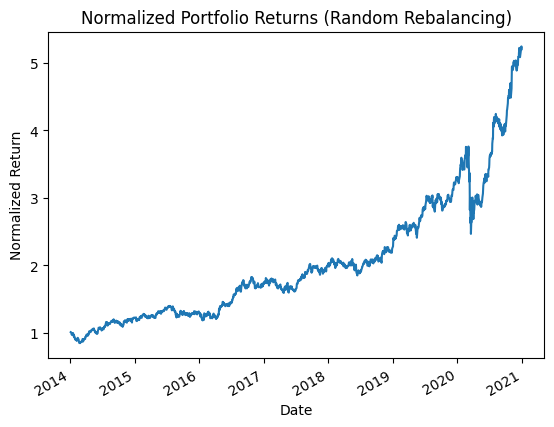

In [43]:
# Plot do um portfólio
normalized_portfolio_returns_random.plot(title='Normalized Portfolio Returns (Random Rebalancing)')
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.show()

In [44]:
from joblib import Parallel, delayed

num_simulations = 100
simulated_portfolios = []
binarray_cumret_dict = {}

def simulate_portfolio():
    binary_array = random_array()
    weights_df_random = random_weights(returns, binary_array)
    normalized_portfolio_returns_random = random_weights_portfolio(returns, weights_df_random)
    
    cumulated_return = normalized_portfolio_returns_random.iloc[-1]
    return cumulated_return, binary_array, normalized_portfolio_returns_random

# Paralelizando a simulação
results = Parallel(n_jobs=-1)(delayed(simulate_portfolio)() for _ in range(num_simulations))

# Separando os resultados
for cumulated_return, binary_array, normalized_portfolio_returns_random in results:
    simulated_portfolios.append(normalized_portfolio_returns_random)
    binarray_cumret_dict[cumulated_return] = binary_array

# Convertendo para DataFrame
simulated_portfolios_df = pd.DataFrame(simulated_portfolios).T

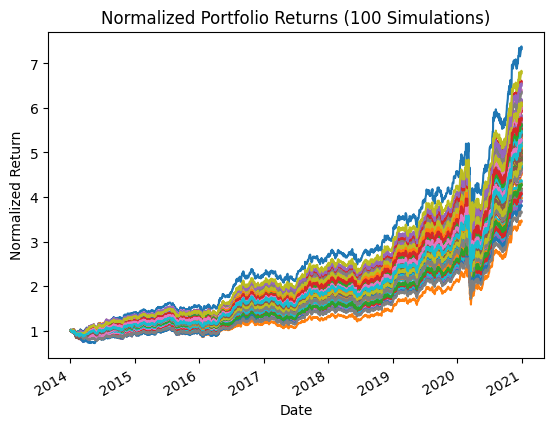

In [45]:
# Plot the results of the simulations
simulated_portfolios_df.plot(title='Normalized Portfolio Returns (100 Simulations)', legend=False)
plt.xlabel('Date')
plt.ylabel('Normalized Return')
plt.show()

In [47]:
binarray_cumret_dict = dict(sorted(binarray_cumret_dict.items(), reverse=True))
binarray_cumret_dict

{7.31923034248055: array([0., 0., 0., ..., 0., 0., 1.]),
 6.776237225128706: array([0., 0., 0., ..., 1., 1., 0.]),
 6.557282163989458: array([0., 0., 0., ..., 0., 1., 1.]),
 6.498115592493876: array([0., 0., 0., ..., 0., 0., 0.]),
 6.36398327513595: array([0., 0., 0., ..., 1., 0., 0.]),
 6.3217989781089265: array([0., 0., 0., ..., 1., 0., 0.]),
 6.151311087724456: array([0., 0., 0., ..., 1., 1., 0.]),
 6.124301774687474: array([0., 0., 0., ..., 0., 0., 0.]),
 6.076949089449471: array([0., 0., 0., ..., 0., 0., 1.]),
 6.076645665128103: array([0., 0., 0., ..., 0., 0., 0.]),
 6.047563130326584: array([0., 0., 0., ..., 0., 0., 0.]),
 6.042455792300893: array([0., 1., 0., ..., 0., 0., 0.]),
 6.0234798997208046: array([0., 1., 0., ..., 0., 1., 1.]),
 5.975017371825884: array([0., 0., 0., ..., 1., 0., 1.]),
 5.97189677316356: array([0., 0., 0., ..., 0., 1., 0.]),
 5.968374027384555: array([0., 0., 0., ..., 0., 0., 0.]),
 5.936840773973879: array([0., 0., 0., ..., 0., 1., 0.]),
 5.913225862164